In [22]:
# Data information:
# https://archive.ics.uci.edu/ml/datasets/Heart+Disease

# Data source
# https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

In [23]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

<ipython-input-23-4556146bd8e1>:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Import and process the data

In [24]:
# import the data
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']


# data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?',np.nan).dropna()

data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


In [25]:
# describe the data
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,DISEASE
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


<ipython-input-26-01da74068307>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


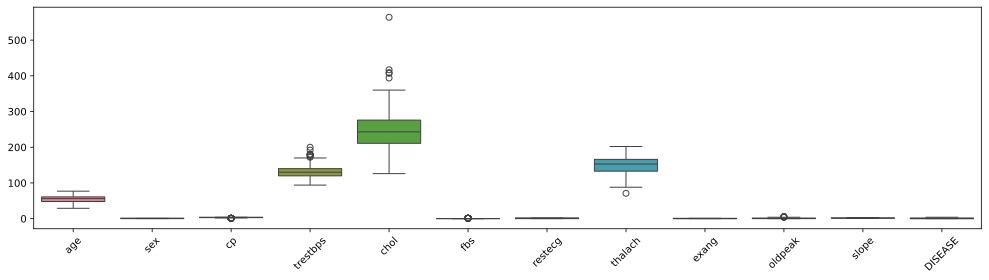

In [26]:
# check the distributions
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [27]:
# z-score the non-categorical columns
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex','fbs','exang','DISEASE'])
cols2zscore

for c in cols2zscore:
  d = pd.to_numeric(data[c]) # force to numeric (addresses some data-format issues)
  data[c] = (d - d.mean())/d.std(ddof=1)

<ipython-input-28-84c4c59f7c1e>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


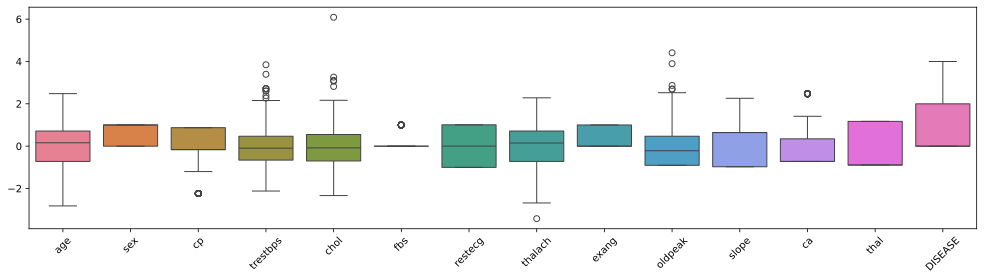

In [28]:
# check the distributions again
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [29]:
# count of all unique types of 'DISEASE'
data['DISEASE'].value_counts()

DISEASE
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64

In [30]:
# re-code events to 0 (absent) and 1 (present)
data['DISEASE'][data['DISEASE']>0] = 1

<ipython-input-30-b5aa9808e59c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DISEASE'][data['DISEASE']>0] = 1


In [31]:
data['DISEASE'].value_counts()#now the data is binarized

DISEASE
0    160
1    137
Name: count, dtype: int64

# Re-organize the data: train/test in DataLoaders

In [32]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[data.keys().drop('DISEASE')].values ).float()
labels = torch.tensor( data['DISEASE'].values ).float()

print( dataT.shape )
print( labels.shape )

# we'll actually need the labels to be a "matrix"
labels = labels[:,None]
print( labels.shape )

torch.Size([297, 13])
torch.Size([297])
torch.Size([297, 1])


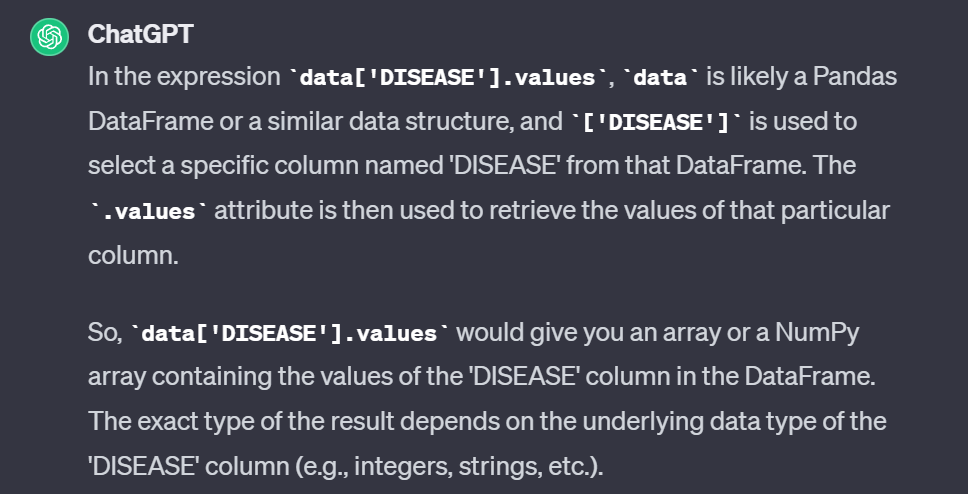

In [33]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=50)

# then convert them into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 20
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [34]:
print(test_data.tensors[0].shape), print(' ')
print(test_data.tensors[0].shape[0])

torch.Size([50, 13])
 
50


In [35]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,  y.shape)

torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])


In [36]:
for X,y in train_loader:
  print(X,  y)

tensor([[-0.3914,  1.0000, -0.1640, -1.2213, -1.3914,  0.0000, -1.0017, -1.1594,
          0.0000, -0.3907, -0.9749, -0.7208, -0.8927],
        [-0.9439,  1.0000, -0.1640,  1.0306, -0.3144,  0.0000, -1.0017, -0.1133,
          0.0000,  2.1820,  0.6427, -0.7208, -0.8927],
        [-0.0599,  1.0000, -0.1640, -0.6583,  0.2048,  0.0000,  1.0085, -0.1133,
          0.0000, -0.5622,  0.6427, -0.7208,  1.1706],
        [ 0.9346,  1.0000,  0.8724, -0.0953,  1.5895,  1.0000,  1.0085, -0.7671,
          1.0000,  0.6384, -0.9749,  2.4742,  1.1706],
        [ 0.9346,  0.0000,  0.8724,  1.0306,  3.0703,  0.0000,  1.0085,  0.1918,
          0.0000,  2.5250,  0.6427,  2.4742,  1.1706],
        [-0.3914,  0.0000, -0.1640,  0.4676,  1.1664,  0.0000,  1.0085, -0.3312,
          0.0000,  0.3811, -0.9749,  0.3442, -0.8927],
        [-2.1594,  1.0000,  0.8724, -0.6583, -0.9491,  0.0000, -1.0017, -0.8543,
          1.0000,  0.4669,  0.6427, -0.7208,  1.1706],
        [ 0.3821,  1.0000,  0.8724, -0.2079,  0.

# Create a class for the DL model

In [37]:
# the class
class theNet(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(13,32)

    ### hidden layers
    self.fc1 = nn.Linear(32,64)
    self.fc2 = nn.Linear(64,10)

    ### output layer
    self.output = nn.Linear(10,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)


In [38]:
# test the model on a bit of data
net = theNet()

X,y = next(iter(train_loader))
yHat = net(X)
print(yHat)

# test the loss function
lossfun = nn.BCEWithLogitsLoss()
lossfun(yHat,y)

tensor([[0.1378],
        [0.1509],
        [0.1410],
        [0.1972],
        [0.1574],
        [0.1466],
        [0.1592],
        [0.1601],
        [0.1762],
        [0.1296],
        [0.1384],
        [0.1655],
        [0.1575],
        [0.1521],
        [0.1464],
        [0.1531],
        [0.1987],
        [0.1445],
        [0.1480],
        [0.1677]], grad_fn=<AddmmBackward0>)


tensor(0.7084, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [39]:
for x,y in train_loader:
  print(x,y)

tensor([[ 0.1611,  1.0000,  0.8724,  0.0172, -1.2183,  0.0000,  1.0085, -1.9440,
          1.0000,  0.8957,  0.6427,  0.3442,  0.6548],
        [ 2.1501,  0.0000, -1.2004, -0.6583,  0.4164,  0.0000,  1.0085, -1.2466,
          1.0000, -0.7337, -0.9749,  0.3442, -0.8927],
        [-0.2809,  1.0000,  0.8724, -0.3768, -0.6798,  0.0000, -1.0017,  0.8021,
          0.0000, -0.0476, -0.9749,  1.4092,  1.1706],
        [-1.4964,  1.0000, -1.2004,  0.1861, -0.8529,  0.0000, -1.0017, -0.7671,
          0.0000, -0.9052,  0.6427, -0.7208,  0.6548],
        [-0.5019,  1.0000,  0.8724,  1.0306, -0.0837,  0.0000,  1.0085, -0.9415,
          0.0000,  1.3244,  0.6427, -0.7208,  1.1706],
        [ 0.8241,  1.0000,  0.8724, -0.6583,  0.3779,  0.0000, -1.0017, -2.2056,
          1.0000,  0.6384,  0.6427,  1.4092,  1.1706],
        [-1.0544,  0.0000, -1.2004, -1.1087, -1.6799,  0.0000, -1.0017, -0.5056,
          0.0000, -0.9052,  0.6427, -0.7208, -0.8927],
        [-0.3914,  0.0000, -0.1640,  0.4676,  1.

In [40]:
for x,y in enumerate(train_loader):
  print(x,y)

0 [tensor([[-1.1649,  1.0000, -1.2004, -0.6583,  0.3010,  0.0000, -1.0017,  1.0200,
          0.0000, -0.9052, -0.9749, -0.7208,  1.1706],
        [ 0.3821,  1.0000,  0.8724, -0.3768,  1.0125,  0.0000,  1.0085,  0.9328,
          0.0000, -0.9052, -0.9749,  1.4092,  1.1706],
        [ 2.4816,  1.0000,  0.8724, -0.3768,  1.0895,  0.0000,  1.0085,  0.5405,
          1.0000, -0.9052, -0.9749,  2.4742, -0.8927],
        [-0.2809,  1.0000, -1.2004,  0.1298, -0.8914,  0.0000, -1.0017,  0.3662,
          0.0000, -0.2191, -0.9749,  0.3442, -0.8927],
        [ 0.4926,  1.0000,  0.8724, -1.2213, -0.1606,  0.0000,  1.0085, -0.3312,
          1.0000,  0.1239,  0.6427,  0.3442,  1.1706],
        [-1.2754,  1.0000, -0.1640, -0.0953,  1.3010,  0.0000, -1.0017,  0.5405,
          0.0000,  0.7241, -0.9749,  0.3442, -0.8927],
        [ 0.2716,  1.0000,  0.8724, -1.2213,  1.6857,  0.0000, -1.0017, -0.2877,
          1.0000,  1.6674,  0.6427,  0.3442,  1.1706],
        [-0.0599,  1.0000,  0.8724, -0.5457, 

# Train the model and show performance

In [41]:
# start with a fresh network
net = theNet()
optimizer = torch.optim.Adam(net.parameters(),lr=.0001)
lossfun = nn.BCEWithLogitsLoss() # try with different loss function


# number of training epochs
numepochs = 150


# initialize losses and accuracies
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)


# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  batchLoss = []
  for X,y in train_loader:

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this batch
    batchLoss.append(loss.item())

    # train accuracy
    predictions = (torch.sigmoid(yHat)>.5).float()
    trainAcc[epochi] = 100*torch.mean((predictions==y).float())

  # end of batch loop...

  # get average losses across the batches
  trainLoss[epochi] = np.mean(batchLoss)


  ## now for the test
  X,y = next(iter(test_loader))
  yHat = net(X)

  # test loss
  loss = lossfun(yHat,y)
  testLoss[epochi] = loss.item()

  # test accuracy
  predictions = (torch.sigmoid(yHat)>.5).float()
  testAcc[epochi] = 100*torch.mean((predictions==y).float())

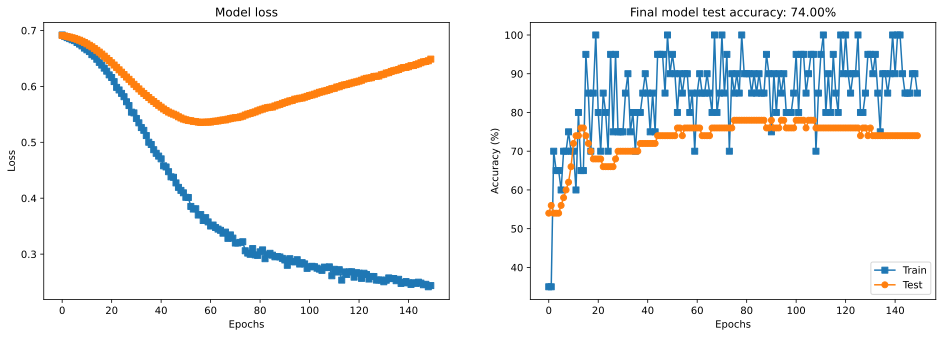

In [42]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'s-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()